In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('default')
from sklearn import cluster
from sklearn.cluster import KMeans
import math
import plotly.graph_objects as pgo
import plotly
plotly.offline.init_notebook_mode(connected=True) 
from sklearn.model_selection import train_test_split

In [3]:
user_history = pd.read_csv('user_history.csv')
user_ratings = pd.read_csv('user_ratings.csv')
id_list = list(user_history['USER ID'])
num_users = len(id_list)

# Cosine Similarity: which leads to clustering

After trying some neural network models (which gave bad results), I decided to explore any structure in the dataset. For that I used cosine similarity of users.

In [3]:
similarity = np.identity(num_users, dtype=float)
new_frame = user_history.set_index(['USER ID'])

The cell below computes cosine similarity for all pairs of 4500 users. It takes long to run. To avoid running it and just seeing the result, run the cell with np.load below to load a pre-computed, saved matrix.

In [ ]:
for i in range(num_users):
    for j in range(i):
        id_1 = id_list[i]
        id_2 = id_list[j]
        v_1 = np.array(list(new_frame.loc[id_1]))
        v_2 = np.array(list(new_frame.loc[id_2]))
        similarity[i][j] = (np.dot(v_1,v_2))/(np.linalg.norm(v_1)*np.linalg.norm(v_2))

In [ ]:
np.save('similarity_matix.npy', similarity)

In [4]:
similarity = np.load('similarity_matrix.npy')

In [5]:
values = (similarity-np.identity(num_users, dtype=float)).flatten()
values_cleaned = [x for x in values if x!=0.0]
smallest = min(values_cleaned)
largest = max(values_cleaned)
print('Smallest and largest similarity values are:', smallest, largest)

Smallest and largest similarity values are: 0.4929819343126177 0.9910480907819392


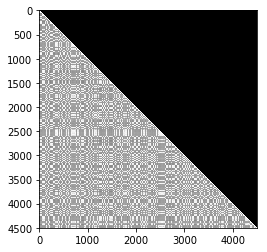

In [6]:
plt.rcParams["axes.grid"] = False #required to remove a white grid from the figure
plt.imshow(similarity, cmap='gray')

In the plot of the similarity matrix above, the patterns of grey and white imply that there are certainly some groups of similar users.

In [7]:
high_similarity_index_pairs = []
for i in range(num_users):
    for j in range(i):
        if similarity[i][j] > 0.99:
            high_similarity_index_pairs.append((i,j))

In [8]:
high_similarity_index_pairs #pairs with similarity > 0.99

[(1524, 761),
 (1643, 1520),
 (1967, 1102),
 (2141, 514),
 (2436, 1137),
 (2481, 536),
 (2696, 717),
 (3058, 413),
 (3062, 1461),
 (3137, 361),
 (3180, 1003),
 (3259, 492),
 (3423, 752),
 (3620, 2852),
 (3802, 1719),
 (3984, 2119)]

Let's make a scatter plot of all cosine similarity values for a single fixed user while varying the other user.

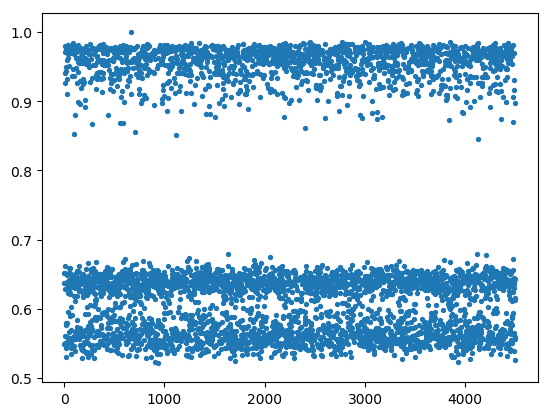

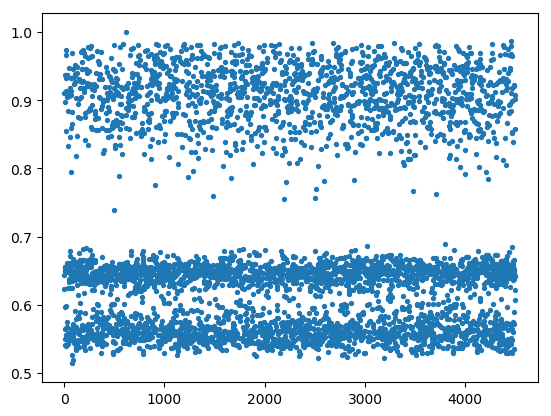

In [9]:
plt.style.use('default')
def scatter_plot_similarity(c, similarity):
    similarity_comp = similarity+similarity.T-np.identity(num_users) #similarity_completed - makes the full symmetric matrix
    col = [(i,similarity_comp[i][c]) for i in range(num_users)]
    plt.scatter([x[0] for x in col],[x[1] for x in col],s=8)
    
    plt.show()
    return

scatter_plot_similarity(666, similarity) #shows separation into 3 similarity types
scatter_plot_similarity(612, similarity) #shows separation into 3 similarity types

From these and thousands of other graphs, it is clear that for each user all the remaining users can be divided into three sets based on cosine similarities. Thus, there are three sets of users which point in the same direction from origin(because cosine similarity tells us the cosine of the angle between lines drawn from origin). Thus there must be 3 clusters of users. We thus proceed to clustering.

The cell below produces all 4500 scatter plots for all users. This takes long to run. It is meant only for demonstration purposes and will not be used in the analysis any further. So feel free to skip running this cell.

In [ ]:
#this cell is used to generate cosine similarity graphs for all points
#the graphs are all available at: 
#this cell takes produces 4500 scatter plots and takes long to run

for c in range(num_users):
    similarity_comp = similarity+similarity.T-np.identity(num_users) #similarity_completed - makes the full symmetric matrix
    col = [(i,similarity_comp[i][c]) for i in range(num_users)]
    plt.clf()
    plt.scatter([x[0] for x in col],[x[1] for x in col], s=10)
    plt.savefig('figs/{}.png'.format(c))

# Clustering

### Checking for right number of clusters

In [4]:
user_history_vectors = user_history.drop(columns=['USER ID']).to_numpy()

In [5]:
ratings_table = user_ratings.pivot(index='USER ID', columns='PRODUCT', values='RATING') #u

In [ ]:
l = []
for k in range(1,101):
    kmeans = KMeans(n_clusters=k)

    kmeans.fit(user_history_vectors)
    l.append(kmeans.inertia_)
    
np.save('kmeans errors vs k.npy',np.array(l))

In [ ]:
plt.plot(range(1,101), l)

In [11]:
l = np.load('kmeans errors vs k.npy')

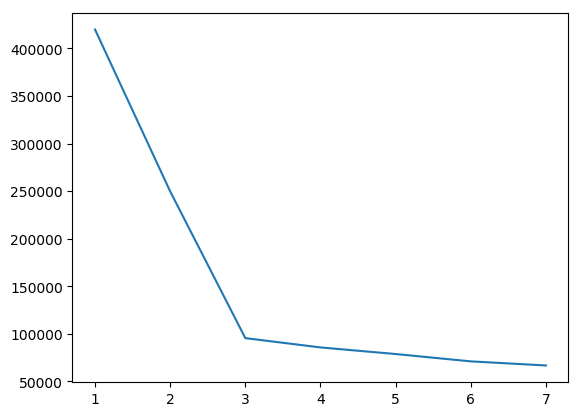

In [12]:
plt.plot(range(1,8),l[:7])

Thus the right number of clusters indeed seems to be 3 from the plot above, as there is an elbow at 3 in the graph of objective function vs $k$.

### Plotting the clusters

1) Projecting onto space formed by first two principal components

Projection onto space formed by first 2 principal components:


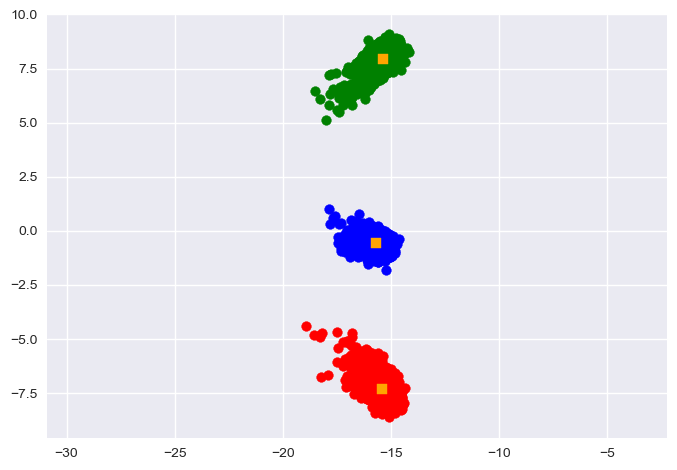

In [6]:
plt.style.use('seaborn')

def project_PCA(data, centroid_coords, desired_proj_dim): #takes data points and the desired dimension of the projection space 
    #and projects onto the space defined by the relevant number of initial principal components
    data = data.T
    U, S, VT = np.linalg.svd(data)
    return (U.T[:desired_proj_dim]@data).T, (U.T[:desired_proj_dim]@(centroid_coords.T)).T

def draw_PCA_projection2D(pca_projections, kmeans, centroid_coords, k): #draw projection onto the first 2 principal components
    colors = ['g','b','r','y']
    data_labels = {key:[] for key in range(k)}
    for i in range(pca_projections.shape[0]): #keep a dictionary of all points in a given cluster
        data_labels[kmeans.labels_[i]].append(pca_projections[i])

    for i in range(k):
        x = [data_labels[i][j][0] for j in range(len(data_labels[i]))] #create list of x-coordinates in the cluster
        y = [data_labels[i][j][1] for j in range(len(data_labels[i]))] #create list of y-coordinates in the cluster
        plt.scatter(x, y, c=colors[i])
        plt.scatter(centroid_coords[i][0],centroid_coords[i][1], c = 'orange', marker = 's')
    plt.axis('equal')
    print('Projection onto space formed by first 2 principal components:')
    plt.show()
    return 

k = 3
kmeans = cluster.KMeans(k)
kmeans.fit(user_history_vectors)
desired_proj_dim = 2
PCA_projections, centroid_coords = project_PCA(user_history_vectors, kmeans.cluster_centers_, desired_proj_dim)
draw_PCA_projection2D(PCA_projections, kmeans, centroid_coords, k)

2) Projecting onto space formed by first three principal components

In [36]:

def draw_PCA_projection3D(pca_projections, kmeans, centroid_coords, k):
    projection = pgo.Figure(data=pgo.Scatter3d(x=pca_projections[:,0], y=pca_projections[:,1], z=pca_projections[:,2], mode="markers", marker=dict(
        size=5,
        opacity=0.8,
        color=kmeans.labels_, #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )))
    projection.update_layout(xaxis=dict(showline=True))
    projection.show()
    return


desired_proj_dim = 3
PCA_projections, centroid_coords = project_PCA(user_history_vectors, kmeans.cluster_centers_, desired_proj_dim)
draw_PCA_projection3D(PCA_projections, kmeans, centroid_coords, k)

#If the plot does not show then run the top cell which has the command plotly.offline.init_notebook_mode(connected=True) 

3) Orthogonally projecting onto the 3-dimensional space formed by the three cluster centers

In [11]:
def project_centroids(data, centroids, kmeans, k):
    Q, _ = np.linalg.qr(centroids.T)
    projected_coordinates = (Q.T@data.T).T
    centroid_coords = (Q.T@centroids.T).T
    projection = pgo.Figure(data=pgo.Scatter3d(x=projected_coordinates[:,0], y=projected_coordinates[:,1], z=projected_coordinates[:,2], mode="markers", marker=dict(
        size=5,
        opacity=0.8,
        color=kmeans.labels_, #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )))
    projection.update_layout(xaxis=dict(showline=True))
    projection.show()
    print('projection onto 3-dim space formed by 3 cluster center for k=3-means clustering:')
    return

project_centroids(user_history_vectors, kmeans.cluster_centers_, kmeans, k)

projection onto 3-dim space formed by 3 cluster center for k=3-means clustering:


In [20]:
def find_cos(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

c = kmeans.cluster_centers_
print('Similarity between cluster centers:', find_cos(c[0],c[1]),find_cos(c[0],c[2]),find_cos(c[2],c[1]))

Similarity between cluster centers: 0.6646522783162266 0.6705254722640939 0.6263488285402974


In [22]:
# Number of points in each cluster

pd.Series(kmeans.labels_).value_counts()

2    1500
1    1500
0    1500
dtype: int64

### Visualizing each cluster

In [14]:
labels = kmeans.labels_

Variance captured by first 2 for cluster 0 0.4792697277460182
Variance captured by first 2 for cluster 1 0.550153433465084
Variance captured by first 2 for cluster 2 0.5066869721177627


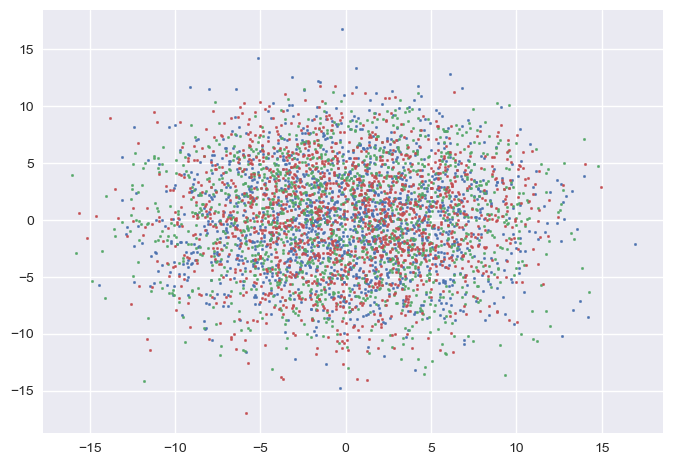

In [44]:
def cluster_plot(labels, fancy, cluster_number):
    
    l=[]
    for i in range(len(labels)):
        if labels[i]==cluster_number:
            l.append(fancy[i])

    data_matrix = np.array(l).T
    data_matrix=data_matrix - np.mean(data_matrix, axis=1, keepdims=True)
    data_matrix=data_matrix/np.std(data_matrix, axis=1, keepdims=True)
    U, S, VT = np.linalg.svd(data_matrix)
    print('Variance captured by first 2 for cluster', cluster_number, (S[0]**2+S[1]**2)/sum(S**2))
    x_coords, y_coords=U.T[0]@data_matrix,U.T[1]@data_matrix
    plt.scatter(x_coords, y_coords,s=3)

cluster_plot(labels, user_history_vectors, 0)
cluster_plot(labels, user_history_vectors, 1)
cluster_plot(labels, user_history_vectors, 2)

In [25]:
def cluster_plot(labels, user_history_vectors, cluster_number):
    
    l=[]
    for i in range(len(labels)):
        if labels[i]==cluster_number:
            l.append(user_history_vectors[i])
    
    data_matrix = np.array(l).T
    data_matrix=data_matrix - np.mean(data_matrix, axis=1, keepdims=True)
    data_matrix=data_matrix/np.std(data_matrix, axis=1, keepdims=True)
    
    U, S, VT = np.linalg.svd(data_matrix)
    x_coords, y_coords, z_coords=U.T[0]@data_matrix,U.T[1]@data_matrix,U.T[2]@data_matrix
    
    projection = pgo.Figure(data=pgo.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode="markers", marker=dict(
        size=3,
        opacity=0.9,
        color=5, #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )))
    projection.update_layout(xaxis=dict(showline=True))
    projection.show()

cluster_plot(labels, user_history_vectors, 0)
cluster_plot(labels, user_history_vectors, 1)
cluster_plot(labels, user_history_vectors, 2)

Projections onto the first 3 principaal components of the Clusters look like parabolids. The distribution in the z-coordinate(third principal comonent) is aslo interesting. It is not uniform or gaussian but a strictly increasing/decreasing distributuoin. Hence we must include it in our analysis and prediction models. Infact, the first two principal components capture only half the variance, it takes about 50 principal components to capture 80-90% of variance thus we must use many/most principal components in our predictions.

# Exploring/Visualizing Product Ratings

We now try to visualize the ratings on each cluster by plotting the ratings as a color gradient on the scatter plot for first three principal components. Cluster number clust_num might need to be any of 0, 1, 2 when one runs the clustering to get the exact graph below. This is because the cluster numbers might be assigned differently on different executions of k-means.

In [10]:
# Cluster number clust_num might need to be any of 0, 1, 2 when one runs the clustering to get the exact graph below.
# This is because the cluster numbers might be assigned differently on different executions of k-means.

prod = 'alaska basil'
clust_num = 0
curr_clust_labels = pd.Series(labels == clust_num, index=pd.Index(user_history['USER ID']))

M = user_history.set_index('USER ID')[curr_clust_labels].to_numpy().T
meen = np.mean(M,axis=1,keepdims=True)
M = M-meen
sd = np.std(M,axis=1,keepdims=True)
M = M/sd

U, S, VT = np.linalg.svd(M)

curr_clust_users_hist = user_history.set_index(user_history['USER ID']).drop(columns=['USER ID'])[curr_clust_labels]

curr_clust_raters = curr_clust_labels.loc[list(ratings_table.index)]

prod_ratings=ratings_table[curr_clust_raters][prod].dropna()
prod_raters_vects = curr_clust_users_hist.loc[prod_ratings.index].to_numpy().T
prod_raters_vects = prod_raters_vects - meen
prod_raters_vects = prod_raters_vects/sd

projection = pgo.Figure(data=pgo.Scatter3d(x=(U.T@prod_raters_vects)[0], y=(U.T@prod_raters_vects)[1], z=(U.T@prod_raters_vects)[2], mode="markers", marker=dict(
    size=3,
    opacity=0.9,
    color=prod_ratings, #set color equal to a variable
    colorscale='Viridis', # one of plotly colorscales
    showscale=True
)))
projection.update_layout(xaxis=dict(showline=True))
projection.show()


There is a clear color gradient with respect to first two principal components. Let's plot the ratings as a function of the first two principal components.

In [49]:

def plot_ratings(prod, clust_num, labels, user_history):
    curr_clust_labels = pd.Series(labels == clust_num, index=pd.Index(user_history['USER ID']))

    M = user_history.set_index('USER ID')[curr_clust_labels].to_numpy().T
    meen = np.mean(M,axis=1,keepdims=True)
    M = M-meen
    sd = np.std(M,axis=1,keepdims=True)
    M = M/sd

    U, S, VT = np.linalg.svd(M)

    curr_clust_users_hist = user_history.set_index(user_history['USER ID']).drop(columns=['USER ID'])[curr_clust_labels]

    curr_clust_raters = curr_clust_labels.loc[list(ratings_table.index)]

    prod_ratings=ratings_table[curr_clust_raters][prod].dropna()
    prod_raters_vects = curr_clust_users_hist.loc[prod_ratings.index].to_numpy().T
    prod_raters_vects = prod_raters_vects - meen
    prod_raters_vects = prod_raters_vects/sd

    projection = pgo.Figure(data=pgo.Scatter3d(x=(U.T@prod_raters_vects)[0], y=(U.T@prod_raters_vects)[1], z=prod_ratings, mode="markers", marker=dict(
        size=3,
        opacity=0.9,
        color=prod_ratings, #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )))
    projection.update_layout(xaxis=dict(showline=True))
    projection.show()
    return prod_raters_vects.T, prod_ratings
    
prod = 'alaska basil'
clust_num = 0
prod_raters_vects, prod_ratings = plot_ratings(prod, clust_num, labels, user_history)

We see a nice, almost linear dependence of the product rating (height/z-coord) on the first two principal components. This suggests that linear regression might be a good model for this. 

### Using linear regression for prediction

In [50]:
def lin_reg_predict(prod_raters_vects, prod_ratings, split_ratio):
    x_train, x_test, y_train, y_test = train_test_split(prod_raters_vects, prod_ratings, test_size=split_ratio, random_state=42)
    A = np.vstack([x_train.T, np.ones(x_train.shape[0])]).T  
    b  = y_train
    result = np.linalg.lstsq(A, b, rcond=None)
    tup = result[0]
    x = tup[:-1]
    c = tup[-1]

    A_test = np.vstack([x_test.T, np.ones(x_test.shape[0])]).T  
    y_pred = [round(val) for val in A_test@(np.append(x,c))]
    ratings_differences=[]

    for i in range(len(y_pred)):
        ratings_differences.append(y_pred[i]-list(y_test)[i])

    difference_counts = pd.Series(ratings_differences).value_counts()
    accuracy = difference_counts[0.0]/sum(difference_counts)

    return difference_counts, accuracy
                                                        
diff_cnt, acc = lin_reg_predict(prod_raters_vects, prod_ratings, 0.2)   
print('Difference counts on test set are:\n', diff_cnt)
print('Accuracy on test set is:', acc)

Difference counts on test set are:
  0.0    82
 1.0    11
-1.0     9
dtype: int64
Accuracy on test set is: 0.803921568627451


We see that the linear regression gives rather accurate results. The ratings on the test set are either correct or are off just by 1! (they could in theory be off by any number)
Let's plot the graph for the same cluster, but some other products to understand things better.

In [47]:
prod_raters_vects, prod_ratings = plot_ratings('alice ticket', 1, labels, user_history)
diff_cnt, acc = lin_reg_predict(prod_raters_vects, prod_ratings, 0.2)   
print('Difference counts on test set are:\n', diff_cnt)
print('Accuracy on test set is:', acc)

NameError: name 'lin_reg_predict' is not defined

We see that linear regression does poorly in the case of this second product.

In [94]:
prod_raters_vects, prod_ratings = plot_ratings('cinema complex', 1, labels, user_history)
diff_cnt, acc = lin_reg_predict(prod_raters_vects, prod_ratings, 0.2)   
print('Difference counts on test set are:\n', diff_cnt)
print('Accuracy on test set is:', acc)

Difference counts are:
  0.0    51
 1.0    21
-1.0    17
 2.0     6
-2.0     5
dtype: int64
Accuracy is: 0.51


In [52]:
prod_raters_vects, prod_ratings = plot_ratings('comedy clean', 0, labels, user_history)
diff_cnt, acc = lin_reg_predict(prod_raters_vects, prod_ratings, 0.2)   
print('Difference counts on test set are:\n', diff_cnt)
print('Accuracy on test set is:', acc)

Difference counts on test set are:
  0.0    51
-1.0    24
 1.0    19
-2.0     2
 2.0     1
dtype: int64
Accuracy on test set is: 0.5257731958762887


Linear regression doesn't do so well for some other products. From the graphs above, it seems that some sort of an activation, like sigmoid is being used. This suggests that the recommender system model with the p's as user history data and sigmoid activations might be the right model.

# Predictions using Recommender System Model

In [55]:
def fit_batchsize_one(lr,epochs,k,p_u,product_ratings):
    q = np.random.normal(size=(k,))
    #order = np.array(range(len(product_ratings)))
    for e in range(epochs):
        gr_q = np.zeros(k)
        #np.random.shuffle(order)
        for o in range(len(product_ratings)):
            
            r = product_ratings[o]
            p = p_u[o]
            gr_q += find_gradient_sigmoid(r, p, q)
        q = q-lr*gr_q/len(product_ratings)
        print('Epoch {}/{} - training set total rating error: {}'.format(e+1, epochs, find_training_loss(p_u,q,product_ratings)))
    return q

def find_training_loss(p_u,q,product_ratings):
    s=0
    for i in range(len(product_ratings)):
        r = product_ratings[i]
        p = p_u[i]
        sig = sigmoid(np.dot(p,q))
        s+=(10*sig-r)**2
    return s
    
def sigmoid(x):
    return 1/(1+math.exp(-x))
    
def find_gradient_sigmoid(r, p, q):
    pu_T_qm = np.dot(p,q)
    sig = sigmoid(pu_T_qm)
    gr_q = 2*(10*sig-r)*10*sig*(1-sig)*p    
    return gr_q

x_train, x_test, y_train, y_test = train_test_split(prod_raters_vects, prod_ratings, test_size=0.2, random_state=42)
k = 100 #all 100 coordinates to be used - this sounds weird but earlier it was the first k principal comp and I don't want to change my functions
lr = 0.01
epochs = 5000
print('Training with batch size one with sigmoid activation')
q = fit_batchsize_one(lr,epochs,k,x_train,list(y_train))

Training with batch size one with sigmoid activation
Epoch 1/5000 - training set total rating error: 14185.492927880863
Epoch 2/5000 - training set total rating error: 13930.19714372471
Epoch 3/5000 - training set total rating error: 13666.075259853626
Epoch 4/5000 - training set total rating error: 13360.317817083102
Epoch 5/5000 - training set total rating error: 12988.398974697713
Epoch 6/5000 - training set total rating error: 12585.468546580156
Epoch 7/5000 - training set total rating error: 12219.45465591843
Epoch 8/5000 - training set total rating error: 11924.101265580604
Epoch 9/5000 - training set total rating error: 11672.284163443666
Epoch 10/5000 - training set total rating error: 11440.2848717396
Epoch 11/5000 - training set total rating error: 11224.026312616234
Epoch 12/5000 - training set total rating error: 11011.560520963962
Epoch 13/5000 - training set total rating error: 10794.185294189785
Epoch 14/5000 - training set total rating error: 10578.38295894128
Epoch 15/

Epoch 152/5000 - training set total rating error: 2888.025577421479
Epoch 153/5000 - training set total rating error: 2883.634493496938
Epoch 154/5000 - training set total rating error: 2879.328091161407
Epoch 155/5000 - training set total rating error: 2875.104269944984
Epoch 156/5000 - training set total rating error: 2870.96123801114
Epoch 157/5000 - training set total rating error: 2866.8974727828395
Epoch 158/5000 - training set total rating error: 2862.9116790777307
Epoch 159/5000 - training set total rating error: 2859.0027461515574
Epoch 160/5000 - training set total rating error: 2855.1697049521745
Epoch 161/5000 - training set total rating error: 2851.41168676492
Epoch 162/5000 - training set total rating error: 2847.7278842846204
Epoch 163/5000 - training set total rating error: 2844.117515982838
Epoch 164/5000 - training set total rating error: 2840.579794455981
Epoch 165/5000 - training set total rating error: 2837.1138992474043
Epoch 166/5000 - training set total rating e

Epoch 324/5000 - training set total rating error: 2550.616776391301
Epoch 325/5000 - training set total rating error: 2548.7708030504064
Epoch 326/5000 - training set total rating error: 2546.9165134474038
Epoch 327/5000 - training set total rating error: 2545.053993101534
Epoch 328/5000 - training set total rating error: 2543.1833494747175
Epoch 329/5000 - training set total rating error: 2541.3047134795092
Epoch 330/5000 - training set total rating error: 2539.418241010437
Epoch 331/5000 - training set total rating error: 2537.524114487145
Epoch 332/5000 - training set total rating error: 2535.6225443963126
Epoch 333/5000 - training set total rating error: 2533.7137708172745
Epoch 334/5000 - training set total rating error: 2531.798064914525
Epoch 335/5000 - training set total rating error: 2529.8757303783827
Epoch 336/5000 - training set total rating error: 2527.947104793206
Epoch 337/5000 - training set total rating error: 2526.0125609109127
Epoch 338/5000 - training set total rati

Epoch 488/5000 - training set total rating error: 2360.713570627702
Epoch 489/5000 - training set total rating error: 2360.0924926531443
Epoch 490/5000 - training set total rating error: 2359.4677829419384
Epoch 491/5000 - training set total rating error: 2358.839317573623
Epoch 492/5000 - training set total rating error: 2358.2069864652094
Epoch 493/5000 - training set total rating error: 2357.570695380549
Epoch 494/5000 - training set total rating error: 2356.9303680489847
Epoch 495/5000 - training set total rating error: 2356.285948369582
Epoch 496/5000 - training set total rating error: 2355.6374026698736
Epoch 497/5000 - training set total rating error: 2354.984721980123
Epoch 498/5000 - training set total rating error: 2354.3279242760177
Epoch 499/5000 - training set total rating error: 2353.6670566347416
Epoch 500/5000 - training set total rating error: 2353.002197242019
Epoch 501/5000 - training set total rating error: 2352.33345718164
Epoch 502/5000 - training set total rating

Epoch 649/5000 - training set total rating error: 2288.9786695286766
Epoch 650/5000 - training set total rating error: 2288.6796485938003
Epoch 651/5000 - training set total rating error: 2288.3795621551117
Epoch 652/5000 - training set total rating error: 2288.078370322992
Epoch 653/5000 - training set total rating error: 2287.776033838865
Epoch 654/5000 - training set total rating error: 2287.472514129091
Epoch 655/5000 - training set total rating error: 2287.167773362533
Epoch 656/5000 - training set total rating error: 2286.861774511769
Epoch 657/5000 - training set total rating error: 2286.554481418032
Epoch 658/5000 - training set total rating error: 2286.245858859869
Epoch 659/5000 - training set total rating error: 2285.9358726255373
Epoch 660/5000 - training set total rating error: 2285.6244895890577
Epoch 661/5000 - training set total rating error: 2285.3116777899763
Epoch 662/5000 - training set total rating error: 2284.997406516687
Epoch 663/5000 - training set total rating

Epoch 793/5000 - training set total rating error: 2243.2872314185884
Epoch 794/5000 - training set total rating error: 2243.0703969404312
Epoch 795/5000 - training set total rating error: 2242.8549515686823
Epoch 796/5000 - training set total rating error: 2242.6408705743715
Epoch 797/5000 - training set total rating error: 2242.428129614308
Epoch 798/5000 - training set total rating error: 2242.216704734031
Epoch 799/5000 - training set total rating error: 2242.0065723697758
Epoch 800/5000 - training set total rating error: 2241.7977093495692
Epoch 801/5000 - training set total rating error: 2241.590092893535
Epoch 802/5000 - training set total rating error: 2241.383700613432
Epoch 803/5000 - training set total rating error: 2241.178510511524
Epoch 804/5000 - training set total rating error: 2240.974500978864
Epoch 805/5000 - training set total rating error: 2240.771650792977
Epoch 806/5000 - training set total rating error: 2240.5699391150683
Epoch 807/5000 - training set total ratin

Epoch 962/5000 - training set total rating error: 2215.682892181181
Epoch 963/5000 - training set total rating error: 2215.539609951216
Epoch 964/5000 - training set total rating error: 2215.396342094942
Epoch 965/5000 - training set total rating error: 2215.253086201024
Epoch 966/5000 - training set total rating error: 2215.109839870616
Epoch 967/5000 - training set total rating error: 2214.9666007170163
Epoch 968/5000 - training set total rating error: 2214.823366365268
Epoch 969/5000 - training set total rating error: 2214.6801344517817
Epoch 970/5000 - training set total rating error: 2214.5369026239564
Epoch 971/5000 - training set total rating error: 2214.3936685398003
Epoch 972/5000 - training set total rating error: 2214.2504298675553
Epoch 973/5000 - training set total rating error: 2214.107184285336
Epoch 974/5000 - training set total rating error: 2213.963929480717
Epoch 975/5000 - training set total rating error: 2213.820663150395
Epoch 976/5000 - training set total rating 

Epoch 1136/5000 - training set total rating error: 2188.817116486924
Epoch 1137/5000 - training set total rating error: 2188.6345991646235
Epoch 1138/5000 - training set total rating error: 2188.451468081144
Epoch 1139/5000 - training set total rating error: 2188.26771602561
Epoch 1140/5000 - training set total rating error: 2188.083335752658
Epoch 1141/5000 - training set total rating error: 2187.8983199850563
Epoch 1142/5000 - training set total rating error: 2187.712661416493
Epoch 1143/5000 - training set total rating error: 2187.5263527145457
Epoch 1144/5000 - training set total rating error: 2187.3393865237945
Epoch 1145/5000 - training set total rating error: 2187.1517554691636
Epoch 1146/5000 - training set total rating error: 2186.963452159419
Epoch 1147/5000 - training set total rating error: 2186.774469190859
Epoch 1148/5000 - training set total rating error: 2186.5847991512605
Epoch 1149/5000 - training set total rating error: 2186.394434623946
Epoch 1150/5000 - training se

Epoch 1291/5000 - training set total rating error: 2152.7227924946583
Epoch 1292/5000 - training set total rating error: 2152.4826377855115
Epoch 1293/5000 - training set total rating error: 2152.243154819443
Epoch 1294/5000 - training set total rating error: 2152.0043427222017
Epoch 1295/5000 - training set total rating error: 2151.7662000355967
Epoch 1296/5000 - training set total rating error: 2151.5287247370843
Epoch 1297/5000 - training set total rating error: 2151.29191425959
Epoch 1298/5000 - training set total rating error: 2151.055765511552
Epoch 1299/5000 - training set total rating error: 2150.8202748971094
Epoch 1300/5000 - training set total rating error: 2150.585438336341
Epoch 1301/5000 - training set total rating error: 2150.3512512855077
Epoch 1302/5000 - training set total rating error: 2150.117708757261
Epoch 1303/5000 - training set total rating error: 2149.8848053407023
Epoch 1304/5000 - training set total rating error: 2149.652535221308
Epoch 1305/5000 - training 

Epoch 1442/5000 - training set total rating error: 2119.3930561755783
Epoch 1443/5000 - training set total rating error: 2119.1552475776557
Epoch 1444/5000 - training set total rating error: 2118.916736456259
Epoch 1445/5000 - training set total rating error: 2118.677514293207
Epoch 1446/5000 - training set total rating error: 2118.437572662006
Epoch 1447/5000 - training set total rating error: 2118.196903234115
Epoch 1448/5000 - training set total rating error: 2117.9554977854764
Epoch 1449/5000 - training set total rating error: 2117.713348203267
Epoch 1450/5000 - training set total rating error: 2117.4704464929405
Epoch 1451/5000 - training set total rating error: 2117.2267847855014
Epoch 1452/5000 - training set total rating error: 2116.9823553450556
Epoch 1453/5000 - training set total rating error: 2116.7371505766187
Epoch 1454/5000 - training set total rating error: 2116.4911630342117
Epoch 1455/5000 - training set total rating error: 2116.2443854291837
Epoch 1456/5000 - trainin

Epoch 1561/5000 - training set total rating error: 2086.264433658984
Epoch 1562/5000 - training set total rating error: 2085.9780469789985
Epoch 1563/5000 - training set total rating error: 2085.6925057183253
Epoch 1564/5000 - training set total rating error: 2085.4078283345675
Epoch 1565/5000 - training set total rating error: 2085.124032333298
Epoch 1566/5000 - training set total rating error: 2084.841134255312
Epoch 1567/5000 - training set total rating error: 2084.5591496663237
Epoch 1568/5000 - training set total rating error: 2084.278093149075
Epoch 1569/5000 - training set total rating error: 2083.997978297799
Epoch 1570/5000 - training set total rating error: 2083.7188177150806
Epoch 1571/5000 - training set total rating error: 2083.440623011035
Epoch 1572/5000 - training set total rating error: 2083.163404804744
Epoch 1573/5000 - training set total rating error: 2082.8871727279293
Epoch 1574/5000 - training set total rating error: 2082.611935430781
Epoch 1575/5000 - training s

Epoch 1712/5000 - training set total rating error: 2050.9623283363194
Epoch 1713/5000 - training set total rating error: 2050.746830437873
Epoch 1714/5000 - training set total rating error: 2050.531174540107
Epoch 1715/5000 - training set total rating error: 2050.3153555055087
Epoch 1716/5000 - training set total rating error: 2050.0993682380767
Epoch 1717/5000 - training set total rating error: 2049.88320768241
Epoch 1718/5000 - training set total rating error: 2049.666868822814
Epoch 1719/5000 - training set total rating error: 2049.450346682426
Epoch 1720/5000 - training set total rating error: 2049.233636322369
Epoch 1721/5000 - training set total rating error: 2049.0167328409034
Epoch 1722/5000 - training set total rating error: 2048.7996313726003
Epoch 1723/5000 - training set total rating error: 2048.582327087541
Epoch 1724/5000 - training set total rating error: 2048.3648151905254
Epoch 1725/5000 - training set total rating error: 2048.147090920285
Epoch 1726/5000 - training se

Epoch 1884/5000 - training set total rating error: 2008.102110402307
Epoch 1885/5000 - training set total rating error: 2007.8012773062687
Epoch 1886/5000 - training set total rating error: 2007.4996840385306
Epoch 1887/5000 - training set total rating error: 2007.1973291814734
Epoch 1888/5000 - training set total rating error: 2006.8942113781084
Epoch 1889/5000 - training set total rating error: 2006.5903293330935
Epoch 1890/5000 - training set total rating error: 2006.2856818137427
Epoch 1891/5000 - training set total rating error: 2005.9802676510292
Epoch 1892/5000 - training set total rating error: 2005.6740857405623
Epoch 1893/5000 - training set total rating error: 2005.367135043542
Epoch 1894/5000 - training set total rating error: 2005.0594145877162
Epoch 1895/5000 - training set total rating error: 2004.7509234682873
Epoch 1896/5000 - training set total rating error: 2004.44166084882
Epoch 1897/5000 - training set total rating error: 2004.1316259621117
Epoch 1898/5000 - traini

Epoch 2003/5000 - training set total rating error: 1967.1681196821464
Epoch 2004/5000 - training set total rating error: 1966.7880382088001
Epoch 2005/5000 - training set total rating error: 1966.4076208425638
Epoch 2006/5000 - training set total rating error: 1966.0268789202698
Epoch 2007/5000 - training set total rating error: 1965.645823966499
Epoch 2008/5000 - training set total rating error: 1965.2644676901537
Epoch 2009/5000 - training set total rating error: 1964.8828219804682
Epoch 2010/5000 - training set total rating error: 1964.5008989024584
Epoch 2011/5000 - training set total rating error: 1964.1187106917932
Epoch 2012/5000 - training set total rating error: 1963.736269749062
Epoch 2013/5000 - training set total rating error: 1963.3535886334587
Epoch 2014/5000 - training set total rating error: 1962.9706800558488
Epoch 2015/5000 - training set total rating error: 1962.5875568712108
Epoch 2016/5000 - training set total rating error: 1962.2042320704636
Epoch 2017/5000 - trai

Epoch 2168/5000 - training set total rating error: 1903.8553669450068
Epoch 2169/5000 - training set total rating error: 1903.42518818201
Epoch 2170/5000 - training set total rating error: 1902.9932056105317
Epoch 2171/5000 - training set total rating error: 1902.559394490256
Epoch 2172/5000 - training set total rating error: 1902.1237305031887
Epoch 2173/5000 - training set total rating error: 1901.6861897816812
Epoch 2174/5000 - training set total rating error: 1901.246748937279
Epoch 2175/5000 - training set total rating error: 1900.8053850904414
Epoch 2176/5000 - training set total rating error: 1900.3620759011214
Epoch 2177/5000 - training set total rating error: 1899.9167996001497
Epoch 2178/5000 - training set total rating error: 1899.4695350214859
Epoch 2179/5000 - training set total rating error: 1899.020261635244
Epoch 2180/5000 - training set total rating error: 1898.5689595815195
Epoch 2181/5000 - training set total rating error: 1898.1156097049773
Epoch 2182/5000 - trainin

Epoch 2338/5000 - training set total rating error: 1815.2222041545294
Epoch 2339/5000 - training set total rating error: 1814.7350071252927
Epoch 2340/5000 - training set total rating error: 1814.2484063023467
Epoch 2341/5000 - training set total rating error: 1813.7623799194184
Epoch 2342/5000 - training set total rating error: 1813.2769062084762
Epoch 2343/5000 - training set total rating error: 1812.7919634089662
Epoch 2344/5000 - training set total rating error: 1812.3075297765747
Epoch 2345/5000 - training set total rating error: 1811.8235835915234
Epoch 2346/5000 - training set total rating error: 1811.3401031664416
Epoch 2347/5000 - training set total rating error: 1810.8570668538066
Epoch 2348/5000 - training set total rating error: 1810.374453052973
Epoch 2349/5000 - training set total rating error: 1809.892240216832
Epoch 2350/5000 - training set total rating error: 1809.4104068580843
Epoch 2351/5000 - training set total rating error: 1808.9289315551666
Epoch 2352/5000 - trai

Epoch 2487/5000 - training set total rating error: 1739.4171159375462
Epoch 2488/5000 - training set total rating error: 1738.8371769804378
Epoch 2489/5000 - training set total rating error: 1738.2558941496902
Epoch 2490/5000 - training set total rating error: 1737.6732656595168
Epoch 2491/5000 - training set total rating error: 1737.0892899041805
Epoch 2492/5000 - training set total rating error: 1736.503965458387
Epoch 2493/5000 - training set total rating error: 1735.9172910776053
Epoch 2494/5000 - training set total rating error: 1735.3292656983567
Epoch 2495/5000 - training set total rating error: 1734.739888438443
Epoch 2496/5000 - training set total rating error: 1734.149158597133
Epoch 2497/5000 - training set total rating error: 1733.5570756552975
Epoch 2498/5000 - training set total rating error: 1732.9636392754803
Epoch 2499/5000 - training set total rating error: 1732.3688493019092
Epoch 2500/5000 - training set total rating error: 1731.7727057604698
Epoch 2501/5000 - train

Epoch 2640/5000 - training set total rating error: 1637.0709907946534
Epoch 2641/5000 - training set total rating error: 1636.3335427508591
Epoch 2642/5000 - training set total rating error: 1635.5954462000016
Epoch 2643/5000 - training set total rating error: 1634.8567057253786
Epoch 2644/5000 - training set total rating error: 1634.1173260940245
Epoch 2645/5000 - training set total rating error: 1633.377312266574
Epoch 2646/5000 - training set total rating error: 1632.6366694069675
Epoch 2647/5000 - training set total rating error: 1631.8954028920516
Epoch 2648/5000 - training set total rating error: 1631.1535183209937
Epoch 2649/5000 - training set total rating error: 1630.4110215245555
Epoch 2650/5000 - training set total rating error: 1629.6679185741402
Epoch 2651/5000 - training set total rating error: 1628.9242157906717
Epoch 2652/5000 - training set total rating error: 1628.179919753228
Epoch 2653/5000 - training set total rating error: 1627.4350373074315
Epoch 2654/5000 - trai

Epoch 2759/5000 - training set total rating error: 1548.24283040112
Epoch 2760/5000 - training set total rating error: 1547.5322198017534
Epoch 2761/5000 - training set total rating error: 1546.8229529335479
Epoch 2762/5000 - training set total rating error: 1546.1150394576096
Epoch 2763/5000 - training set total rating error: 1545.4084885986533
Epoch 2764/5000 - training set total rating error: 1544.7033091508147
Epoch 2765/5000 - training set total rating error: 1543.9995094839298
Epoch 2766/5000 - training set total rating error: 1543.2970975502526
Epoch 2767/5000 - training set total rating error: 1542.596080891532
Epoch 2768/5000 - training set total rating error: 1541.8964666464688
Epoch 2769/5000 - training set total rating error: 1541.198261558469
Epoch 2770/5000 - training set total rating error: 1540.5014719836706
Epoch 2771/5000 - training set total rating error: 1539.8061038992146
Epoch 2772/5000 - training set total rating error: 1539.1121629117176
Epoch 2773/5000 - traini

Epoch 2878/5000 - training set total rating error: 1473.5291794787427
Epoch 2879/5000 - training set total rating error: 1472.9766191219635
Epoch 2880/5000 - training set total rating error: 1472.4250057787438
Epoch 2881/5000 - training set total rating error: 1471.87432841945
Epoch 2882/5000 - training set total rating error: 1471.3245759085319
Epoch 2883/5000 - training set total rating error: 1470.77573700405
Epoch 2884/5000 - training set total rating error: 1470.2278003571316
Epoch 2885/5000 - training set total rating error: 1469.680754511395
Epoch 2886/5000 - training set total rating error: 1469.1345879022979
Epoch 2887/5000 - training set total rating error: 1468.5892888564524
Epoch 2888/5000 - training set total rating error: 1468.0448455908786
Epoch 2889/5000 - training set total rating error: 1467.5012462122208
Epoch 2890/5000 - training set total rating error: 1466.9584787159101
Epoch 2891/5000 - training set total rating error: 1466.4165309852863
Epoch 2892/5000 - trainin

Epoch 3048/5000 - training set total rating error: 1381.349917020636
Epoch 3049/5000 - training set total rating error: 1380.7593680137518
Epoch 3050/5000 - training set total rating error: 1380.1683949673143
Epoch 3051/5000 - training set total rating error: 1379.5770205621645
Epoch 3052/5000 - training set total rating error: 1378.9852673908406
Epoch 3053/5000 - training set total rating error: 1378.3931579218008
Epoch 3054/5000 - training set total rating error: 1377.8007144647488
Epoch 3055/5000 - training set total rating error: 1377.2079591372435
Epoch 3056/5000 - training set total rating error: 1376.6149138326673
Epoch 3057/5000 - training set total rating error: 1376.021600189704
Epoch 3058/5000 - training set total rating error: 1375.428039563389
Epoch 3059/5000 - training set total rating error: 1374.8342529978615
Epoch 3060/5000 - training set total rating error: 1374.24026120089
Epoch 3061/5000 - training set total rating error: 1373.6460845202303
Epoch 3062/5000 - trainin

Epoch 3168/5000 - training set total rating error: 1311.2963572657109
Epoch 3169/5000 - training set total rating error: 1310.7363917040018
Epoch 3170/5000 - training set total rating error: 1310.1769101192324
Epoch 3171/5000 - training set total rating error: 1309.6179080278146
Epoch 3172/5000 - training set total rating error: 1309.0593806432332
Epoch 3173/5000 - training set total rating error: 1308.5013228780906
Epoch 3174/5000 - training set total rating error: 1307.9437293464453
Epoch 3175/5000 - training set total rating error: 1307.3865943665078
Epoch 3176/5000 - training set total rating error: 1306.8299119636333
Epoch 3177/5000 - training set total rating error: 1306.2736758736132
Epoch 3178/5000 - training set total rating error: 1305.7178795462287
Epoch 3179/5000 - training set total rating error: 1305.162516149093
Epoch 3180/5000 - training set total rating error: 1304.6075785717182
Epoch 3181/5000 - training set total rating error: 1304.0530594298298
Epoch 3182/5000 - tra

Epoch 3342/5000 - training set total rating error: 1211.224554974153
Epoch 3343/5000 - training set total rating error: 1210.5601317104088
Epoch 3344/5000 - training set total rating error: 1209.893728902377
Epoch 3345/5000 - training set total rating error: 1209.2253286730654
Epoch 3346/5000 - training set total rating error: 1208.5549131586072
Epoch 3347/5000 - training set total rating error: 1207.8824645135212
Epoch 3348/5000 - training set total rating error: 1207.2079649162174
Epoch 3349/5000 - training set total rating error: 1206.5313965748062
Epoch 3350/5000 - training set total rating error: 1205.852741733162
Epoch 3351/5000 - training set total rating error: 1205.1719826773228
Epoch 3352/5000 - training set total rating error: 1204.489101742139
Epoch 3353/5000 - training set total rating error: 1203.8040813182781
Epoch 3354/5000 - training set total rating error: 1203.1169038595197
Epoch 3355/5000 - training set total rating error: 1202.4275518903708
Epoch 3356/5000 - traini

Epoch 3517/5000 - training set total rating error: 1062.7595872399602
Epoch 3518/5000 - training set total rating error: 1061.809103152903
Epoch 3519/5000 - training set total rating error: 1060.8580746283233
Epoch 3520/5000 - training set total rating error: 1059.9064727868954
Epoch 3521/5000 - training set total rating error: 1058.9542680036125
Epoch 3522/5000 - training set total rating error: 1058.0014299425811
Epoch 3523/5000 - training set total rating error: 1057.047927591384
Epoch 3524/5000 - training set total rating error: 1056.0937292949977
Epoch 3525/5000 - training set total rating error: 1055.1388027891853
Epoch 3526/5000 - training set total rating error: 1054.1831152333314
Epoch 3527/5000 - training set total rating error: 1053.2266332427046
Epoch 3528/5000 - training set total rating error: 1052.2693229200754
Epoch 3529/5000 - training set total rating error: 1051.3111498866906
Epoch 3530/5000 - training set total rating error: 1050.3520793125763
Epoch 3531/5000 - trai

Epoch 3684/5000 - training set total rating error: 872.0698976925381
Epoch 3685/5000 - training set total rating error: 870.6449867565962
Epoch 3686/5000 - training set total rating error: 869.2168717349749
Epoch 3687/5000 - training set total rating error: 867.7855733616659
Epoch 3688/5000 - training set total rating error: 866.3511119429802
Epoch 3689/5000 - training set total rating error: 864.9135073043848
Epoch 3690/5000 - training set total rating error: 863.4727787375217
Epoch 3691/5000 - training set total rating error: 862.0289449475513
Epoch 3692/5000 - training set total rating error: 860.5820240009951
Epoch 3693/5000 - training set total rating error: 859.1320332741954
Epoch 3694/5000 - training set total rating error: 857.6789894025947
Epoch 3695/5000 - training set total rating error: 856.222908230942
Epoch 3696/5000 - training set total rating error: 854.7638047645919
Epoch 3697/5000 - training set total rating error: 853.3016931220582
Epoch 3698/5000 - training set tota

Epoch 3856/5000 - training set total rating error: 567.2331274701918
Epoch 3857/5000 - training set total rating error: 565.0414294343498
Epoch 3858/5000 - training set total rating error: 562.8492493535058
Epoch 3859/5000 - training set total rating error: 560.6568374679281
Epoch 3860/5000 - training set total rating error: 558.4644451931689
Epoch 3861/5000 - training set total rating error: 556.2723247539406
Epoch 3862/5000 - training set total rating error: 554.0807288173862
Epoch 3863/5000 - training set total rating error: 551.889910126944
Epoch 3864/5000 - training set total rating error: 549.7001211379512
Epoch 3865/5000 - training set total rating error: 547.5116136560995
Epoch 3866/5000 - training set total rating error: 545.3246384797923
Epoch 3867/5000 - training set total rating error: 543.1394450473907
Epoch 3868/5000 - training set total rating error: 540.9562810903174
Epoch 3869/5000 - training set total rating error: 538.7753922928766
Epoch 3870/5000 - training set tota

Epoch 4026/5000 - training set total rating error: 274.2584247179901
Epoch 4027/5000 - training set total rating error: 273.0050671883238
Epoch 4028/5000 - training set total rating error: 271.7556678167249
Epoch 4029/5000 - training set total rating error: 270.51021477895006
Epoch 4030/5000 - training set total rating error: 269.2686966717527
Epoch 4031/5000 - training set total rating error: 268.0311025067948
Epoch 4032/5000 - training set total rating error: 266.79742170450766
Epoch 4033/5000 - training set total rating error: 265.5676440878937
Epoch 4034/5000 - training set total rating error: 264.3417598762817
Epoch 4035/5000 - training set total rating error: 263.1197596790231
Epoch 4036/5000 - training set total rating error: 261.9016344891478
Epoch 4037/5000 - training set total rating error: 260.6873756769689
Epoch 4038/5000 - training set total rating error: 259.47697498364283
Epoch 4039/5000 - training set total rating error: 258.27042451469123
Epoch 4040/5000 - training set

Epoch 4192/5000 - training set total rating error: 118.26325416142943
Epoch 4193/5000 - training set total rating error: 117.6370931129392
Epoch 4194/5000 - training set total rating error: 117.014481134409
Epoch 4195/5000 - training set total rating error: 116.39540928207123
Epoch 4196/5000 - training set total rating error: 115.77986848732472
Epoch 4197/5000 - training set total rating error: 115.16784955795282
Epoch 4198/5000 - training set total rating error: 114.55934317936064
Epoch 4199/5000 - training set total rating error: 113.95433991584106
Epoch 4200/5000 - training set total rating error: 113.35283021186144
Epoch 4201/5000 - training set total rating error: 112.75480439337495
Epoch 4202/5000 - training set total rating error: 112.1602526691546
Epoch 4203/5000 - training set total rating error: 111.56916513214743
Epoch 4204/5000 - training set total rating error: 110.98153176085228
Epoch 4205/5000 - training set total rating error: 110.39734242071668
Epoch 4206/5000 - traini

Epoch 4346/5000 - training set total rating error: 56.534398186337846
Epoch 4347/5000 - training set total rating error: 56.30975535566757
Epoch 4348/5000 - training set total rating error: 56.0867281810094
Epoch 4349/5000 - training set total rating error: 55.86530565807481
Epoch 4350/5000 - training set total rating error: 55.645476841074355
Epoch 4351/5000 - training set total rating error: 55.42723084281905
Epoch 4352/5000 - training set total rating error: 55.210556834811506
Epoch 4353/5000 - training set total rating error: 54.99544404732418
Epoch 4354/5000 - training set total rating error: 54.781881769467866
Epoch 4355/5000 - training set total rating error: 54.56985934924823
Epoch 4356/5000 - training set total rating error: 54.35936619361246
Epoch 4357/5000 - training set total rating error: 54.15039176848531
Epoch 4358/5000 - training set total rating error: 53.94292559879459
Epoch 4359/5000 - training set total rating error: 53.73695726848713
Epoch 4360/5000 - training set 

Epoch 4514/5000 - training set total rating error: 34.694042868881155
Epoch 4515/5000 - training set total rating error: 34.62825851614803
Epoch 4516/5000 - training set total rating error: 34.562954616568796
Epoch 4517/5000 - training set total rating error: 34.49812765034726
Epoch 4518/5000 - training set total rating error: 34.43377412335922
Epoch 4519/5000 - training set total rating error: 34.36989056696933
Epoch 4520/5000 - training set total rating error: 34.30647353785017
Epoch 4521/5000 - training set total rating error: 34.2435196178016
Epoch 4522/5000 - training set total rating error: 34.181025413571966
Epoch 4523/5000 - training set total rating error: 34.118987556679954
Epoch 4524/5000 - training set total rating error: 34.057402703238125
Epoch 4525/5000 - training set total rating error: 33.996267533776845
Epoch 4526/5000 - training set total rating error: 33.93557875307008
Epoch 4527/5000 - training set total rating error: 33.87533308996211
Epoch 4528/5000 - training se

Epoch 4677/5000 - training set total rating error: 28.408825121553573
Epoch 4678/5000 - training set total rating error: 28.388834935672474
Epoch 4679/5000 - training set total rating error: 28.368989705954167
Epoch 4680/5000 - training set total rating error: 28.349288372799847
Epoch 4681/5000 - training set total rating error: 28.32972988439804
Epoch 4682/5000 - training set total rating error: 28.31031319666761
Epoch 4683/5000 - training set total rating error: 28.291037273200505
Epoch 4684/5000 - training set total rating error: 28.271901085205414
Epoch 4685/5000 - training set total rating error: 28.25290361145171
Epoch 4686/5000 - training set total rating error: 28.23404383821377
Epoch 4687/5000 - training set total rating error: 28.215320759215743
Epoch 4688/5000 - training set total rating error: 28.1967333755767
Epoch 4689/5000 - training set total rating error: 28.1782806957561
Epoch 4690/5000 - training set total rating error: 28.159961735499913
Epoch 4691/5000 - training s

Epoch 4844/5000 - training set total rating error: 26.466788073070614
Epoch 4845/5000 - training set total rating error: 26.460819981549367
Epoch 4846/5000 - training set total rating error: 26.454894678968852
Epoch 4847/5000 - training set total rating error: 26.449011855364407
Epoch 4848/5000 - training set total rating error: 26.4431712030367
Epoch 4849/5000 - training set total rating error: 26.437372416535705
Epoch 4850/5000 - training set total rating error: 26.431615192643623
Epoch 4851/5000 - training set total rating error: 26.42589923035876
Epoch 4852/5000 - training set total rating error: 26.420224230879054
Epoch 4853/5000 - training set total rating error: 26.41458989758602
Epoch 4854/5000 - training set total rating error: 26.40899593602857
Epoch 4855/5000 - training set total rating error: 26.40344205390712
Epoch 4856/5000 - training set total rating error: 26.39792796105781
Epoch 4857/5000 - training set total rating error: 26.3924533694366
Epoch 4858/5000 - training se

In [56]:
l = []
for i in range(len(y_test)):
    y1 = round(10*sigmoid(np.dot(x_test[i],q)))
    y2 = int(list(y_test)[i])
    l.append(y1-y2)
    
accuracy = pd.Series(l).value_counts()[0]/pd.Series(l).shape[0]
print('Accuracy is:', accuracy,'\n','Rating difference counts:\n', pd.Series(l).value_counts())

Accuracy is: 0.8350515463917526 
 Rating difference counts:
  0    81
 1     9
-1     7
dtype: int64


Thus we see that the accuracy improves with the recommender system model. Hence we use this for our predictions.

# A remark about other clusters

When we plot the ratings plot from above for the other two clusters, we do not see a nice pattern like above. Also, these algorithms (linear regression, recommender system with sigmoid activation) do not give good results for these clusters.
Despite trying several times to look for an error, I couldn't find one. Even neural networks do not give good results for the other two clusters. As a result, we simply use the recommender system model for all our predictions.

Below we give one such plot for another cluster.

In [17]:
prod = 'alaska basil'
clust_num = 1
curr_clust_labels = pd.Series(labels == clust_num, index=pd.Index(user_history['USER ID']))

M = user_history.set_index('USER ID')[curr_clust_labels].to_numpy().T
meen = np.mean(M,axis=1,keepdims=True)
M = M-meen
sd = np.std(M,axis=1,keepdims=True)
M = M/sd

U, S, VT = np.linalg.svd(M)

curr_clust_users_hist = user_history.set_index(user_history['USER ID']).drop(columns=['USER ID'])[curr_clust_labels]

curr_clust_raters = curr_clust_labels.loc[list(ratings_table.index)]

prod_ratings=ratings_table[curr_clust_raters][prod].dropna()
prod_raters_vects = curr_clust_users_hist.loc[prod_ratings.index].to_numpy().T
prod_raters_vects = prod_raters_vects - meen
prod_raters_vects = prod_raters_vects/sd

x1 = (U.T@prod_raters_vects)[0]
y1 = (U.T@prod_raters_vects)[1]
z1 = (U.T@prod_raters_vects)[2]
projection = pgo.Figure(data=pgo.Scatter3d(x=x1, y=y1, z=z1, mode="markers", marker=dict(
    size=3,
    opacity=0.9,
    color=prod_ratings, #set color equal to a variable
    colorscale='Viridis', # one of plotly colorscales
    showscale=True
)))
projection.update_layout(xaxis=dict(showline=True))
projection.show()

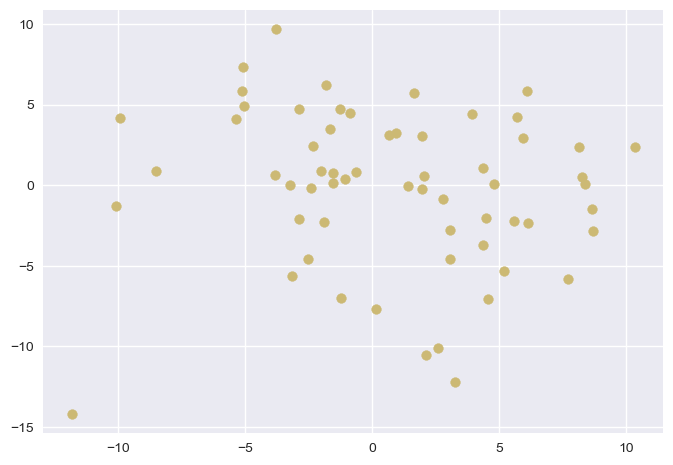

In [37]:
colors = 2*list(mpl.rcParams['axes.prop_cycle'])

for rat in range(11):
    indices_rat = [i for i in range(len(prod_ratings)) if list(prod_ratings)[i]==rat]
    plt.clf()
    plt.scatter([x1[i] for i in indices_rat], [y1[i] for i in indices_rat], c= colors[rat]['color'])
    
    plt.savefig(str(rat)+'.png')

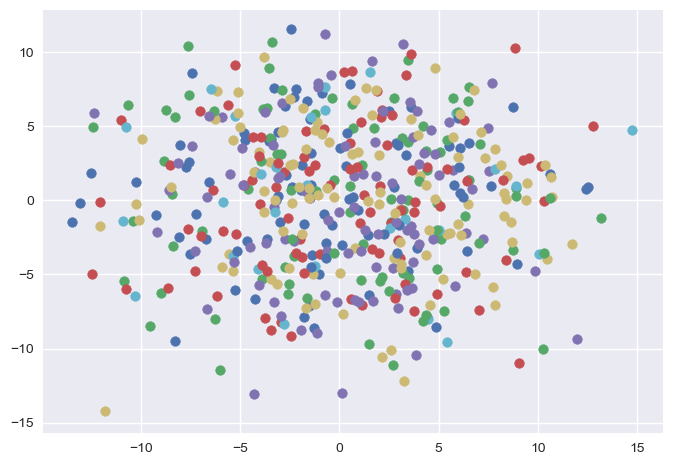

In [39]:
for rat in range(11):
    indices_rat = [i for i in range(len(prod_ratings)) if list(prod_ratings)[i]==rat]
    
    plt.scatter([x1[i] for i in indices_rat], [y1[i] for i in indices_rat])
    
plt.savefig('all.png')

As noted above, this plot does not look very informative. Moreover, I'm not able to get any of the techniques done in the course to get a good result on this cluster.

# Scrach Work - Ignore

In [98]:
ratings_table = user_ratings.pivot(index='USER ID', columns='PRODUCT', values='RATING') #u
raters = list(ratings_table.index)
clust_0_raters = pd.Series(labels==0, index=pd.Index(user_history['USER ID'])).loc[raters] #s
clust_0_ratings = ratings_table[clust_0_raters]
products_list = list(clust_0_ratings.columns)

In [99]:
product = 'alaska basil'
clust_0_ratings_prod = clust_0_ratings[product]
product_points = user_history.set_index('USER ID').loc[list(clust_0_ratings_prod.dropna().index)].to_numpy()
product_ratings = list(clust_0_ratings_prod.dropna())
product_matrix=product_points.T - m
product_matrix=product_matrix/std_dev
x_coords, y_coords, z_coords=U.T[0]@product_matrix,U.T[1]@product_matrix,U.T[2]@product_matrix

projection = pgo.Figure(data=pgo.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode="markers", marker=dict(
    size=3,
    opacity=0.9,
    color=product_ratings, #set color equal to a variable
    colorscale='Viridis', # one of plotly colorscales
    showscale=True
)))
projection.update_layout(xaxis=dict(showline=True))
projection.show()

In [ ]:
print('if k=10 then for a fixed product the model has only 10 parameters with this large a dataset, and just 10 parameters the risk of overfitting is minimal ')

In [ ]:
x0=p_u[:,0]
y0=p_u[:,1]
projection = pgo.Figure(data=pgo.Scatter3d(x=x0, y=y0, z=[10*sigmoid(cc) for cc in q[:2]@((p_u.T)[:2])], mode="markers", marker=dict(
    size=3,
    opacity=0.9,
    color=0, #set color equal to a variable
    colorscale='Viridis', # one of plotly colorscales
    showscale=True
)))
projection.add_scatter3d(x=x_coords, y=y_coords, z=z_coords, mode="markers", marker=dict(
    size=3,
    opacity=0.9,
    color=1, #set color equal to a variable
    colorscale='RdBu', # one of plotly colorscales
    showscale=True
))

projection.update_layout(xaxis=dict(showline=True))
print(product)
projection.show()


In [ ]:
min(p_u.flatten())

In [ ]:
x0=p_u[:,0]
y0=p_u[:,1]
projection = pgo.Figure(data=pgo.Scatter3d(x=x0, y=y0, z=z_coords, mode="markers", marker=dict(
    size=3,
    opacity=0.9,
    color=0, #set color equal to a variable
    colorscale='Viridis', # one of plotly colorscales
    showscale=True
)))
difference  = np.array(z_coords-np.array([round(10*sigmoid(cc)) for cc in q@((p_u.T))]),dtype=int)
x_diff = [x_coords[i] for i in range(len(x_coords)) if difference[i]!=0]
y_diff = [y_coords[i] for i in range(len(x_coords)) if difference[i]!=0]
z_diff = [np.array([round(10*sigmoid(cc)) for cc in q@((p_u.T))])[i]  for i in range(len(x_coords)) if difference[i]!=0]
projection.add_scatter3d(x=x_diff, y=y_diff, z=z_diff, mode="markers", marker=dict(
    size=3,
    opacity=0.9,
    color=1, #set color equal to a variable
    colorscale='RdBu', # one of plotly colorscales
    showscale=True
))

projection.update_layout(xaxis=dict(showline=True))
print(product)
projection.show()


In [ ]:
difference  = np.array(z_coords-np.array([round(10*sigmoid(cc)) for cc in q@((p_u.T))]),dtype=int)
difference

In [ ]:
l = []
l_prime =[]
for i in range(len(product_ratings)):
    l.append(round(10*sigmoid(np.dot(p_u[i],q)))-int(product_ratings[i]))
    l_prime.append(round(10*sigmoid(np.dot(p_u[i][:2],q[:2])))-int(product_ratings[i]))
    
print(pd.Series(l).value_counts())
print(pd.Series(l_prime).value_counts())
print('This indicates that more principal componenets are indeed needed')

In [ ]:
print('train without sigmoid activation!!!')
#but that's just linear regression then